### Set UP
* Robustbench: this library is used for loading robust classifer, For more information visit: https://github.com/RobustBench/robustbench

* foolbox: this library is used for adversarial example generation. For more information visit: https://github.com/bethgelab/foolbox

In [1]:
%%capture
!pip install git+https://github.com/RobustBench/robustbench.git # library for loading robust classifer
!pip install -q foolbox # library for adversarial example generation

In [2]:
from robustbench.utils import clean_accuracy
from robustbench.utils import load_model
import matplotlib.pyplot as plt
from torch import unique
import foolbox as fb
import numpy as np
import pickle
import torch
import os

### Download and preprocess the data:

* We will use 1000 test examples from the cifar 10 dataset. These images are new to the model as it hasn't seen them in the training phase. We want to fool the model on its predictions for new images!

In [3]:
import gdown
output_file = 'cifar10.pt'
file_id = "1A5gQCE0bHZhBlfcLQ2fFP5UygpgVkdAX"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1A5gQCE0bHZhBlfcLQ2fFP5UygpgVkdAX
To: /content/cifar10.pt
100%|██████████| 12.3M/12.3M [00:00<00:00, 33.1MB/s]


'cifar10.pt'

In [4]:
cifar_data = torch.load('cifar10.pt')

<ipython-input-4-b0f49031be72>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cifar_data = torch.load('cifar10.pt')


In [5]:
# Extract the images and labels tensors
x_test = cifar_data['images']
y_test = cifar_data['labels']

print(unique(y_test, return_counts=True))

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))


In [6]:
print(x_test.shape, y_test.shape)
print(torch.max(x_test), torch.min(x_test))

torch.Size([1000, 3, 32, 32]) torch.Size([1000])
tensor(1.) tensor(0.)


### Loading the robust model

* IMPORTANT: You shouldn't change this part of the code as your final generated examples will be evaluated how successful you are at fooling this model!

In [8]:
model = load_model(model_name='Kireev2021Effectiveness_RLATAugMix', dataset='cifar10', threat_model='corruptions')

Downloading...
From (original): https://drive.google.com/uc?id=19HNTdqJiuNyqFqIarPejniJEjZ3RQ_nj
From (redirected): https://drive.google.com/uc?id=19HNTdqJiuNyqFqIarPejniJEjZ3RQ_nj&confirm=t&uuid=5ac1c05d-73bf-4248-ad15-2226cf6755a0
To: /content/models/cifar10/corruptions/Kireev2021Effectiveness_RLATAugMix.pt
100%|██████████| 89.5M/89.5M [00:05<00:00, 17.6MB/s]
/usr/local/lib/python3.10/dist-packages/robustbench/utils.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode 

### GPU Utilization

* For shorter running time, let's utilize GPU!

In [15]:
# Check if GPU is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Using CPU")

model = model.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

Using GPU: Tesla T4


### Adversarial Example Generation -- Adversarial Perturbation

* Here for a baseline, we use the PGD algorithm from foolbox library. This is the most important part of the challenge. What algorithm is gonna work best?

* There are many algorithms and many other adversarial example generation algorithms. Don't forget to check out other libraries!

  * One other very popular library among many others is Adversarial Robustness Toolbox (ART)!
  * There are many more algorithms out there, your task is to find the ones that works best based on our evaluation metrics.

In [ ]:
model_fb = fb.PyTorchModel(model, bounds=(0, 1))

In [17]:
_, advs, success = fb.attacks.LinfPGD(rel_stepsize=0.1, steps=20)(model_fb, x_test, y_test, epsilons=[8/255])

### Let's compare the accuracies before and after perturbation!

In [11]:
print('Robust accuracy: {:.1%}'.format(1 - success.float().mean()))
print(clean_accuracy(model, x_test, y_test))

Robust accuracy: 5.8%
0.941


### Let's explore how our perturbations look!

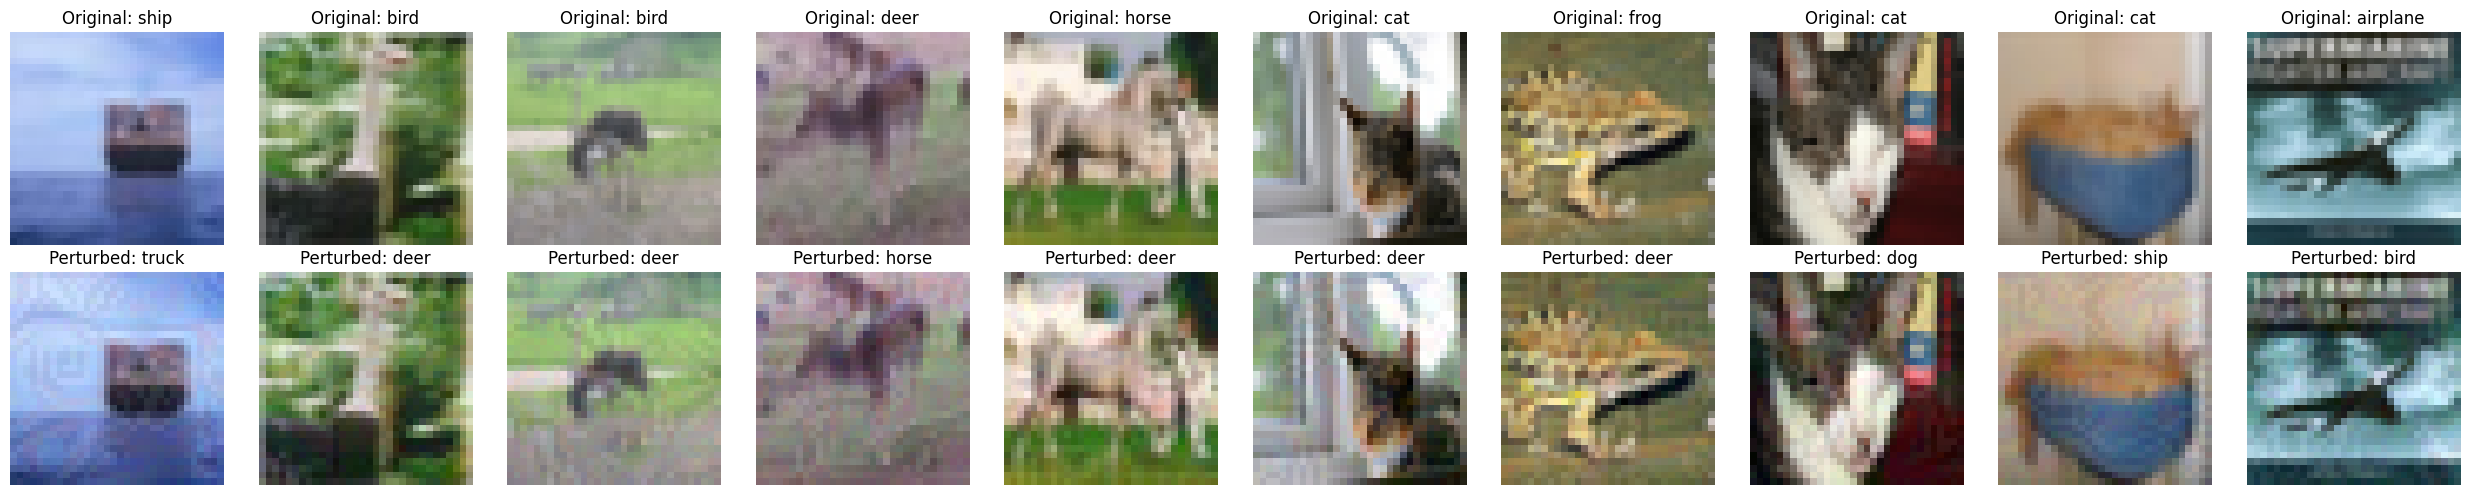

In [14]:
import torch
import matplotlib.pyplot as plt
import random

# Pass the perturbed images through the model to get the predicted labels
with torch.no_grad():  # No need to track gradients during inference
    logits_adv = model(advs[0].to('cuda'))  # Get the logits for the adversarial examples

# Get the predicted labels from the logits
predicted_labels_adv = torch.argmax(logits_adv, dim=1)

# Find which examples were misclassified (where predicted label != true label)
misclassified_indices = (predicted_labels_adv != y_test.to('cuda')).nonzero(as_tuple=True)[0]

# Get the misclassified original and perturbed images, true labels, and incorrect labels
misclassified_images = advs[0][misclassified_indices]
misclassified_original_images = x_test.to('cuda')[misclassified_indices]
misclassified_predicted_labels = predicted_labels_adv[misclassified_indices]
misclassified_true_labels = y_test.to('cuda')[misclassified_indices]

# Choose a random subset of misclassified images to display
num_images_to_show = min(10, len(misclassified_images))  # Limit to 10 images for display
random_indices = random.sample(range(len(misclassified_images)), num_images_to_show)

# Class names (assuming CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the original and misclassified perturbed images side by side
plt.figure(figsize=(25, 5))
for i, idx in enumerate(random_indices):
    # Original image
    original_image = misclassified_original_images[idx]
    true_label = misclassified_true_labels[idx].item()

    # Perturbed image
    perturbed_image = misclassified_images[idx]
    incorrect_label = misclassified_predicted_labels[idx].item()

    # Convert images from tensor to numpy and transpose from (C, H, W) to (H, W, C)
    original_img = original_image.permute(1, 2, 0).cpu().numpy()
    perturbed_img = perturbed_image.permute(1, 2, 0).cpu().numpy()

    # Plot original image
    plt.subplot(2, num_images_to_show, i+1)
    plt.imshow(original_img, interpolation='none')
    plt.title(f"Original: {class_names[true_label]}")
    plt.axis('off')

    # Plot perturbed (misclassified) image
    plt.subplot(2, num_images_to_show, num_images_to_show + i + 1)
    plt.imshow(perturbed_img, interpolation='none')
    plt.title(f"Perturbed: {class_names[incorrect_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Finally!

* Let's save our perturbed samples in a folder called 'challenge' and submit them for the evaluation.

In [16]:
# Create the 'challenge' directory if it doesn't exist
os.makedirs('challenge', exist_ok=True)

# Path to save the adversarial examples
file_path = os.path.join('challenge', 'advs.pkl')

# Save the 'advs' object
with open(file_path, 'wb') as f:
    pickle.dump(advs, f)